In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import nltk;
from nltk.corpus import stopwords;

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

nltk.download('stopwords')
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /Users/avi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

import spacy
nlp  = spacy.load('en_core_web_md')

In [4]:
from sklearn.cluster import KMeans

## 0.0 Load Data

In [5]:
file_name = '/Users/avi/Dropbox/Insight/Project/insight_project/data/interim/charity_data_cleaned_temp.csv'
all_charity = pd.read_csv(file_name)

## 1.0 Pre-process raw text (lamentize and remove stopwords) 

In [6]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

def preprocess_docs(docs):
    result = []
    
    for doc in docs:
        result.append(preprocess(doc))
    
    return result

In [26]:
mission_text = all_charity['description'].astype('str')

#Preprocess mission descriptions
mission_text_pre = preprocess_docs(mission_text)

## 2.0 Convert pre-processed text to vectors and embed

In [36]:
docs_dict = Dictionary(mission_text_pre)

In [29]:
len(docs_dict)

12805

In [40]:
docs_dict.filter_extremes(no_below=3, no_above=.8)

In [42]:
len(docs_dict)

6367

In [43]:
docs_dict.compactify()

In [45]:
docs_corpus = [docs_dict.doc2bow(doc) for doc in mission_text_pre]

In [47]:
docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_corpus])

In [49]:
np.shape(docs_vecs)

(8370, 6367)

In [50]:
docs_vecs[1,:]

array([1., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [52]:
#For each word in dict obtain embedding vector (Glove vectors)
tfidf_emb_vecs = np.vstack([nlp(docs_dict[i]).vector for i in range(len(docs_dict))])
docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 

In [53]:
def word_embed_charity_glove(processed_docs,word_min=5, word_max_perc=.8 ):
    
    'Assumes docs have already been pre-processed'
    
    #Create dictionary from corpus
    docs_dict = Dictionary(processed_docs)
    docs_dict.filter_extremes(no_below=word_min, no_above=word_max_perc)
    docs_dict.compactify()
    
    #Convert docs into tf-idf vectors
    docs_corpus = [docs_dict.doc2bow(doc) for doc in processed_docs]
    docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_corpus])
    
    num_docs= np.shape(docs_vecs)[0]
    num_words = np.shape(docs_vecs)[1]

    print("Total # of docs: {}".format(num_docs))
    print("Total # of words in dict: {}".format(num_words))
    
    #For each word in dict obtain embedding vector (Glove vectors)
    emb_vecs = np.vstack([nlp(docs_dict[i]).vector for i in range(len(docs_dict))])
    
    # Weight glove vectors by tf-idf values
    docs_emb = np.dot(docs_vecs, emb_vecs) 
        
    return docs_emb

In [8]:
def word_embed_charity_tfidf(processed_docs,word_min=5, word_max_perc=.2 ):
    
    'Assumes docs have already been pre-processed'
    
    #Create dictionary from corpus
    docs_dict = Dictionary(processed_docs)
    docs_dict.filter_extremes(no_below=word_min, no_above=word_max_perc)
    docs_dict.compactify()
    
    #Convert docs into tf-idf vectors
    docs_corpus = [docs_dict.doc2bow(doc) for doc in processed_docs]
    model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
    docs_tfidf  = model_tfidf[docs_corpus]
    docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])
    
    num_docs= np.shape(docs_vecs)[0]
    num_words = np.shape(docs_vecs)[1]

    print("Total # of docs: {}".format(num_docs))
    print("Total # of words in dict: {}".format(num_words))
    
    #For each word in dict obtain embedding vector (Glove vectors)
    tfidf_emb_vecs = np.vstack([nlp(docs_dict[i]).vector for i in range(len(docs_dict))])
    
    # Weight glove vectors by tf-idf values
    docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 
        
    return docs_emb, docs_dict, model_tfidf, tfidf_emb_vecs

In [9]:
charity_docs_emb, charity_docs_dict, charity_model_tfidf, charity_tfidf_emb_vecs = word_embed_charity(mission_text_pre,word_min=5, word_max_perc=.2 )

Total # of docs: 8370
Total # of words in dict: 3749


In [12]:
len(charity_docs_dict)

3749

In [13]:
np.shape(charity_tfidf_emb_vecs)

(3749, 300)

In [ ]:
charity_docs_emb_glove = word_embed_charity_glove(mission_text_pre,word_min=0, word_max_perc=1 )

Total # of docs: 8370
Total # of words in dict: 12805


## 3.0 Run Model

In [23]:
def run_kmeans(n_clusters,docs_emb,max_iter = 500, n_init=15):
    
    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=max_iter, n_init=n_init)
    model.fit(docs_emb)
    
    return model

In [193]:
model = run_kmeans(11,charity_docs_emb,max_iter = 500, n_init=15)

In [99]:
all_charity['kmeans_11'] = model.labels_

## 4.0 Preprocess Article

In [14]:
file_name = '/Users/avi/Dropbox/Insight/Project/raw_data/news_data_all.csv'
all_news = pd.read_csv(file_name)

KeyboardInterrupt: 

In [15]:
text= 'PITTSBURGH — Armed with an AR-15-style assault rifle and at least three handguns, a man shouting anti-Semitic slurs opened fire inside a Pittsburgh synagogue Saturday morning, killing at least 11 congregants and wounding four police officers and two others, the authorities said. In a rampage described as among the deadliest against the Jewish community in the United States, the assailant stormed into the Tree of Life Congregation, where worshipers had gathered in separate rooms to celebrate their faith, and shot indiscriminately into the crowd, shattering what had otherwise been a peaceful morning. The assailant, identified by law enforcement officials as Robert D. Bowers, fired for several minutes and was leaving the synagogue when officers, dressed in tactical gear and armed with rifles, met him at the door. According to the police, Mr. Bowers exchanged gunfire with officers before retreating back inside and barricading himself inside a third-floor room. He eventually surrendered. Mr. Bowers, 46, was injured by gunfire, although the authorities said it was unclear whether those wounds were self-inflicted or whether the police had shot him. He was taken to Allegheny General Hospital. Federal officials charged Mr. Bowers with 29 criminal counts. They included obstructing the free exercise of religious beliefs — a hate crime — and using a firearm to commit murder. He also faces state charges, including 11 counts of criminal homicide, six counts of aggravated assault and 13 counts of ethnic intimidation. The authorities said that he had no previous criminal history.Though a bris, a ceremony to mark a child’s birth, was among the ceremonies taking place Saturday, no children were among the casualties, law enforcement officials said. The wounded included a 70-year-old man who had been shot in the torso, and a 61-year-old woman with soft tissue wounds, said Dr. Donald Yealy, chairman of emergency medicine at the University of Pittsburgh School of Medicine. The attack Saturday morning struck the heart of the city’s vibrant Jewish community, in the leafy Squirrel Hill neighborhood that is home to several synagogues, kosher restaurants and bakeries. Hours later, hundreds gathered at three separate interfaith vigils on a cold, rainy evening to mourn the dead and pray for the wounded. The assault on the synagogue unfolded on a quiet, drizzly morning, and came amid a bitter, vitriolic midterm election season and against the backdrop of what appears to be a surge in hate-related speech and crimes across America. It also took place in the wake of the arrest Friday morning of a man who the authorities said sent more than a dozen pipe bombs to critics of Mr. Trump, including several high-profile Democrats. Calling it the  most horrific crime scene  he had seen in 22 years with the F.B.I., Robert Jones, special agent in charge in Pittsburgh, said the synagogue was in the midst of a  peaceful service  when congregants were gunned down and  brutally murdered by a gunman targeting them simply because of their faith.   We simply cannot accept this violence as a normal part of American life,  said Gov. Tom Wolf of Pennsylvania, speaking at a news conference Saturday afternoon in Pittsburgh.  These senseless acts of violence are not who we are as Pennsylvanians and are not who we are as Americans.  The anguish of Saturday’s massacre heightened a sense of national unease over increasingly hostile political rhetoric. Critics of President Trump have argued that he is partly to blame for recent acts of violence because he has been stirring the pot of nationalism, on Twitter and at his rallies, charges that Mr. Trump has denied. About Saturday’s attack, Mr. Trump, addressing reporters at Joint Base Andrews, said:  It’s a terrible, terrible thing what’s going on with hate in our country and frankly all over the world, and something has to be done.   The results are very devastating,  he said, adding that if the temple  had some kind of protection  then  it could have been a much different situation.  Later, speaking to reporters as he got off Air Force One in Illinois, Mr. Trump said he planned to visit Pittsburgh but he did not say when. Leaders in the United States and across the world condemned the attack. Prime Minister Benjamin Netanyahu of Israel said he was  heartbroken and appalled  and that the  the entire people of Israel grieve with the families of the dead.  Attorney General Jeff Sessions said that criminal charges by the Justice Department  could lead to the death penalty.   Hatred and violence on the basis of religion can have no place in our society,  Mr. Sessions said.  Every American has the right to attend their house of worship in safety.  The massacre Saturday was at least the third mass shooting in a house of worship in three years. Last November, a gunman killed 26 worshipers at a church in Sutherland Springs, Tex., and in 2015, a white supremacist killed nine congregants in a church in Charleston, S.C. It came amid rising anxiety about illegal immigration and in a decade that has seen an uptick in hate crimes. According to an annual report by the Anti-Defamation League issued earlier this year, the number of reported anti-Semitic incidents in the United States surged 57 percent in 2017, the largest rise in a single year since the A.D.L. began tracking such crimes in 1979. The attack also was a deep and painful blow to the Jewish community in the United States, and came just days after George Soros, the billionaire philanthropist and major donor to Democratic candidates, who is Jewish and who survived Nazi occupation in Hungary, received a pipe bomb in the mail. Also in the past week, a Senate campaign sign for Josh Hawley, attorney general of Missouri, was sprayed with a swastika.'

In [125]:
def df_topic(df, search_term):
    df['topic'] = all_news['content'].str.find(search_term)
    df_sub = df[df['topic']>-1]
    articles = df_sub['content'].astype('str')
    return articles

In [126]:
cc = df_topic(all_news,'climate change')
homeless = df_topic(all_news,'homeless')
jewish = df_topic(all_news,'jew')

In [187]:
del all_news

In [115]:
def word_embed_articles(processed_docs,doc_dict,model_tfidf,tfidf_emb_vecs):
    
    #Convert docs into tf-idf vectors
    docs_corpus = [docs_dict.doc2bow(doc) for doc in processed_docs]
    docs_tfidf  = model_tfidf[docs_corpus]
    docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])
    
    # sum of glove vectors linearlly weighted by tfidf 
    art_emb = np.dot(docs_vecs, tfidf_emb_vecs)
    
    return art_emb

In [174]:
def process_predict_articles(df, model):
    df_content = df['content'].astype('str')
    df_pre = preprocess_docs(df_content)
    art_embs = word_embed_articles(df_pre,charity_docs_dict,charity_model_tfidf,charity_tfidf_emb_vecs)
    
    predictions = model.predict(art_embs)
    
    df['cluster_predictions'] = predictions
    
    return df
    

In [182]:
def plot_cluster_pred_dist(df):
    df_prediction_dist = df.groupby('cluster_predictions')['index'].count().reset_index()
    
    sns.catplot(y='index',x='cluster_predictions',kind = 'bar', data = df_prediction_dist)
    
    

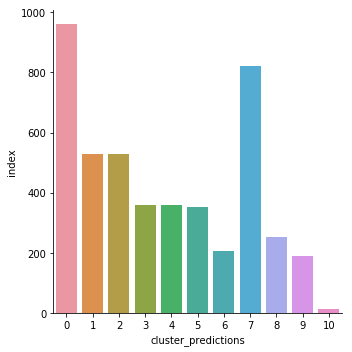

In [197]:
cc_predict = process_predict_articles(cc,model)
plot_cluster_pred_dist(cc_predict)

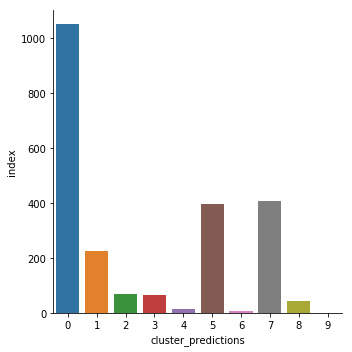

In [194]:
homeless_predict = process_predict_articles(homeless,model)
plot_cluster_pred_dist(homeless_predict)

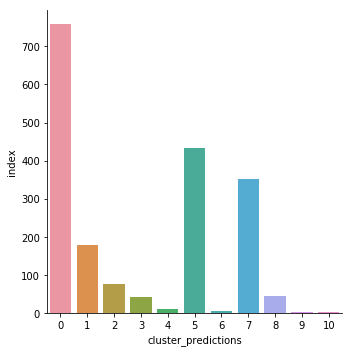

In [195]:
jewish_predict = process_predict_articles(jewish,model)
plot_cluster_pred_dist(jewish_predict)

In [198]:
charity_cluster = all_charity[all_charity['kmeans_11'] == 0]
charity_cluster.groupby('subcategory')['ein'].count()

subcategory
Adult Education Programs and Services                         16
Advocacy and Education                                       110
Animal Rights, Welfare, and Services                          72
Botanical Gardens, Parks, and Nature Centers                   3
Children's and Family Services                               101
Community Foundations                                         28
Development and Relief Services                               97
Diseases, Disorders, and Disciplines                          27
Early Childhood Programs and Services                          8
Education Policy and Reform                                   16
Environmental Protection and Conservation                     33
Food Banks, Food Pantries, and Food Distribution              25
Homeless Services                                             53
Housing and Neighborhood Development                          47
Humanitarian Relief Supplies                                  19
International